In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

sns.set(style='whitegrid')

In [148]:
# Load the dataset
df = pd.read_csv('final1.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,6.9,11.6,4.1
1,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.0,13.0,17.5
2,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.5,13.0,14.0
3,Boulin et al. 2013,Ketzin Claystone,7.0,31.8,15.0,10.4
4,Boulin et al. 2013,Ketzin Claystone,25.0,15.6,15.0,13.0


In [36]:
df.shape

(63, 6)

In [149]:
# Load the dataset
df1 = pd.read_csv('final2.csv')
print("First few rows of the dataset:")
df1.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


In [38]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/1032671506.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


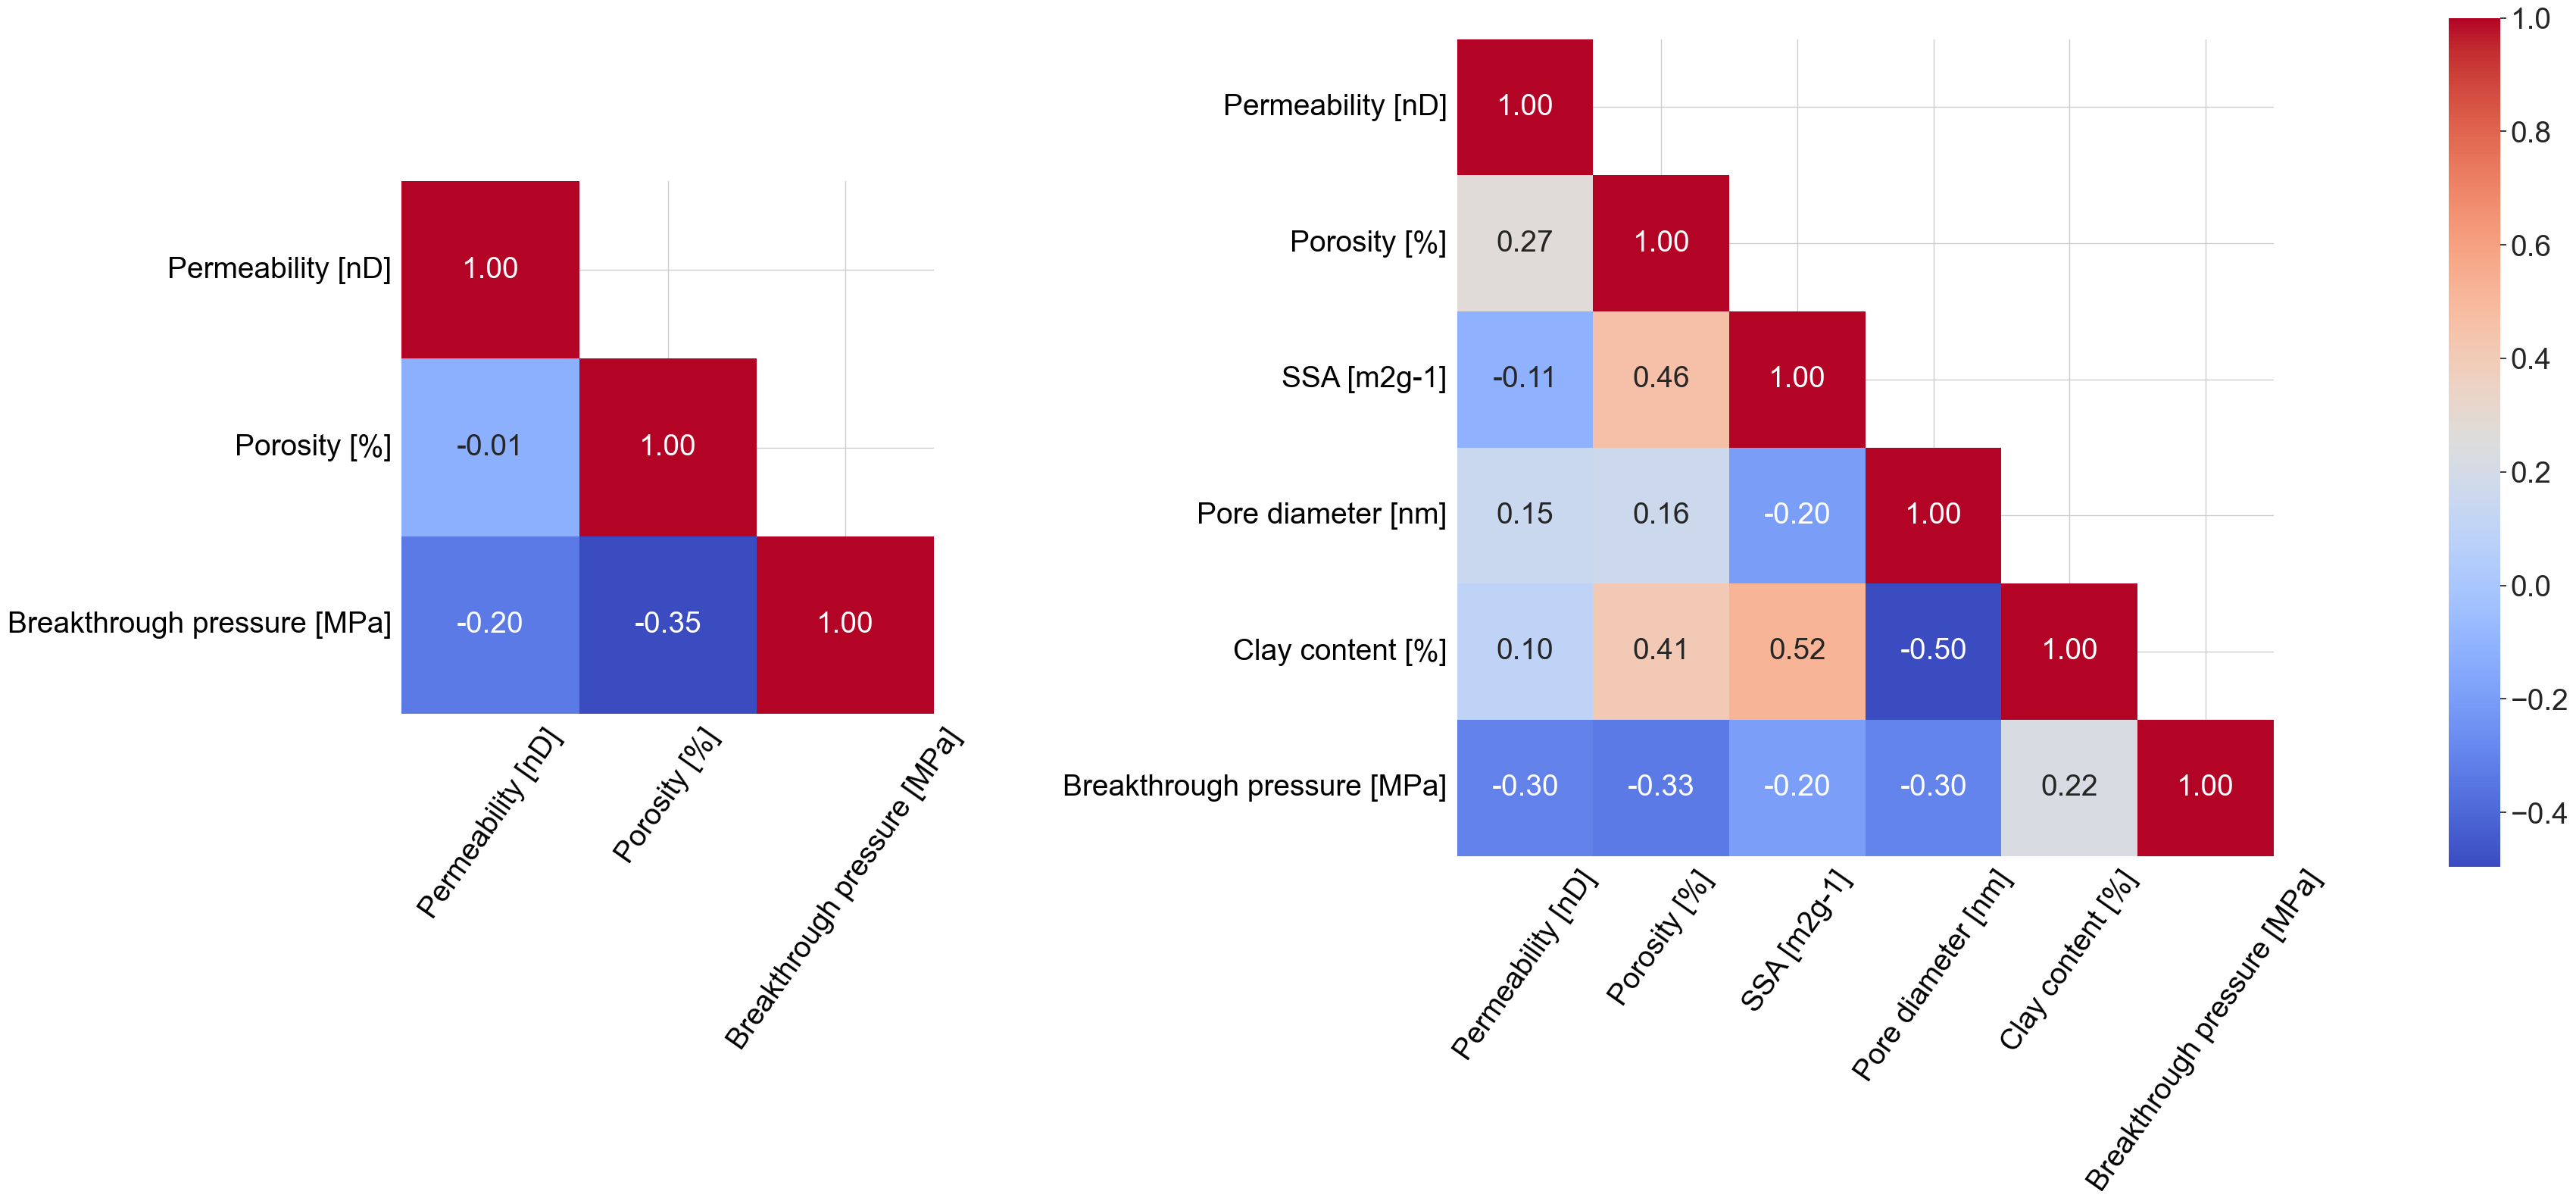

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming df and df1 are your original dataframes
correlation_matrix_df = df[['Permeability [nD]', 'Porosity [%]',
       'Breakthrough pressure [MPa]']].corr()
correlation_matrix_df1 = df1[['Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']].corr()

# Generate masks for upper triangles of both correlation matrices
mask_df = np.triu(np.ones_like(correlation_matrix_df, dtype=bool), k=1)
mask_df1 = np.triu(np.ones_like(correlation_matrix_df1, dtype=bool), k=1)

# Create subplots with adjusted width ratios based on column count
fig, axes = plt.subplots(1, 2, figsize=(34, 14), gridspec_kw={'width_ratios': [len(correlation_matrix_df.columns), len(correlation_matrix_df1.columns)], 'wspace': 0.5})

# Create a shared color bar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

# First heatmap with the mask applied
sns.heatmap(correlation_matrix_df, annot=True, mask=mask_df, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 28}, ax=axes[0], cbar=False, square=True)
axes[0].set_title('', fontsize=28, fontname='Arial')
axes[0].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[0].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')


# Second heatmap with the mask applied and color bar
sns.heatmap(correlation_matrix_df1, annot=True, mask=mask_df1, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 28}, ax=axes[1], cbar_ax=cbar_ax, square=True,
            cbar_kws={'shrink': 1.0, 'ticks': [1, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8 ]})
axes[1].set_title('', fontsize=28, fontname='Arial')
axes[1].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[1].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')

# Set color bar tick size
cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

# Adjust layout and spacing between plots
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.5)

plt.show()


# Prediction of Breakthrough Pressure with 2 Variables: Direct Tests

## Exploratory Data Analysis

In [40]:
# Display the summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
count,59.000000,63.000000,63.000000,63.000000
mean,13.674576,1453.361905,16.095238,5.004603
std,7.136975,5981.324892,12.471457,4.935137
min,3.000000,0.600000,0.100000,0.030000
25%,8.250000,6.950000,5.700000,1.000000
50%,10.000000,29.300000,14.500000,4.100000
75%,20.000000,305.000000,23.600000,5.900000
max,28.000000,44000.000000,54.500000,27.800000


In [41]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Reference                      0
Rock                           0
P’[MPa]                        4
Permeability [nD]              0
Porosity [%]                   0
Breakthrough pressure [MPa]    0
dtype: int64


In [42]:
# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
Reference                       object
Rock                            object
P’[MPa]                        float64
Permeability [nD]              float64
Porosity [%]                   float64
Breakthrough pressure [MPa]    float64
dtype: object


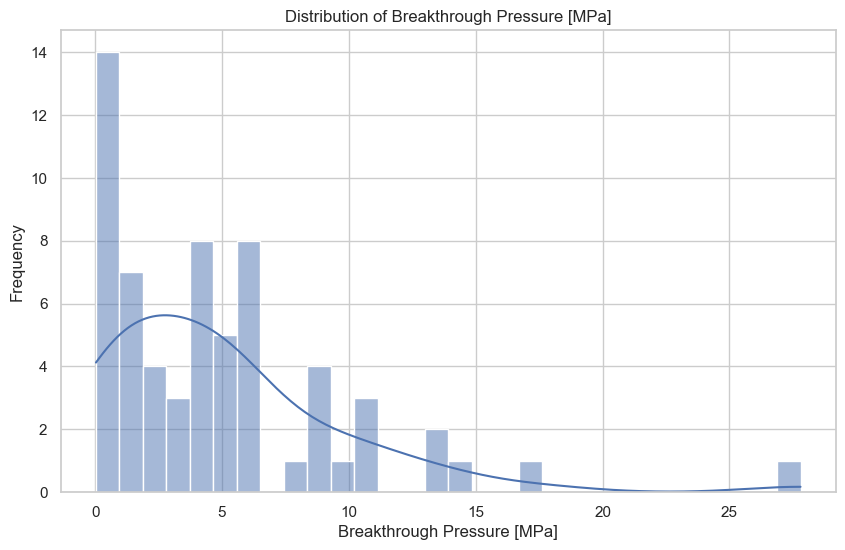

In [43]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Breakthrough pressure [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]')
plt.xlabel('Breakthrough Pressure [MPa]')
plt.ylabel('Frequency')
plt.show()

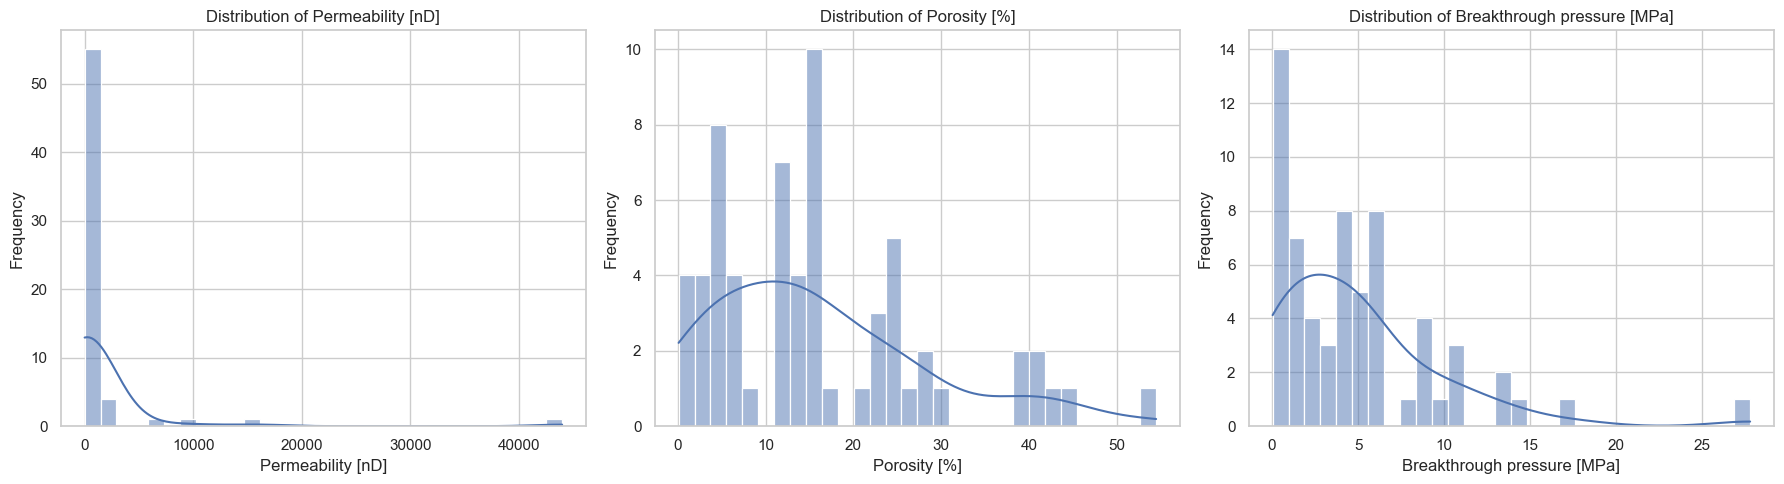

In [44]:
feature_columns = [ 
       'Permeability [nD]', 'Porosity [%]', 'Breakthrough pressure [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

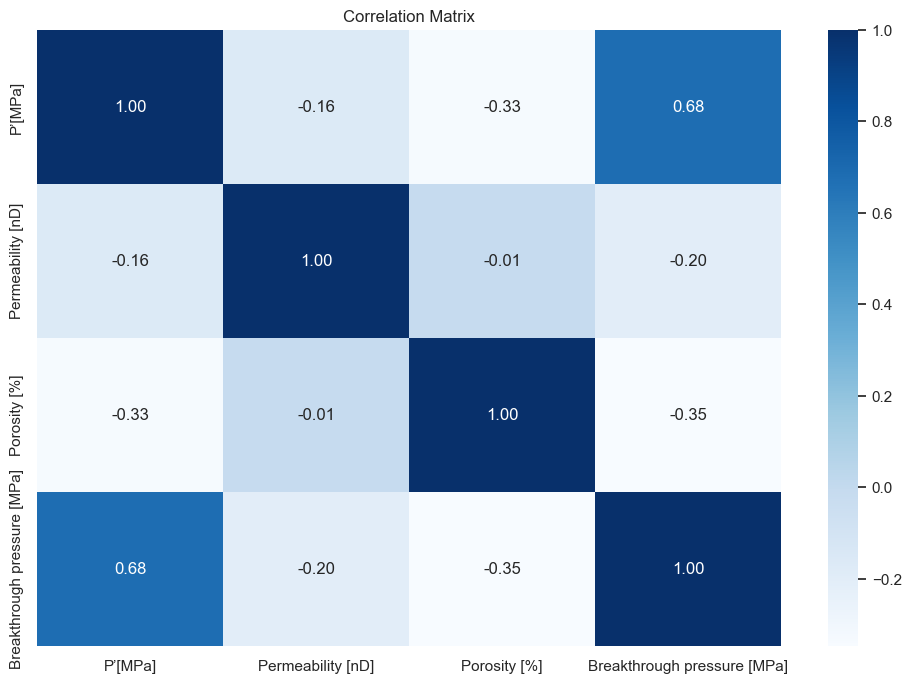

In [45]:
# Visualize correlations between features and the target variable
cols = ['P’[MPa]', 'Permeability [nD]', 'Porosity [%]', 'Breakthrough pressure [MPa]']
correlation_matrix = df[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

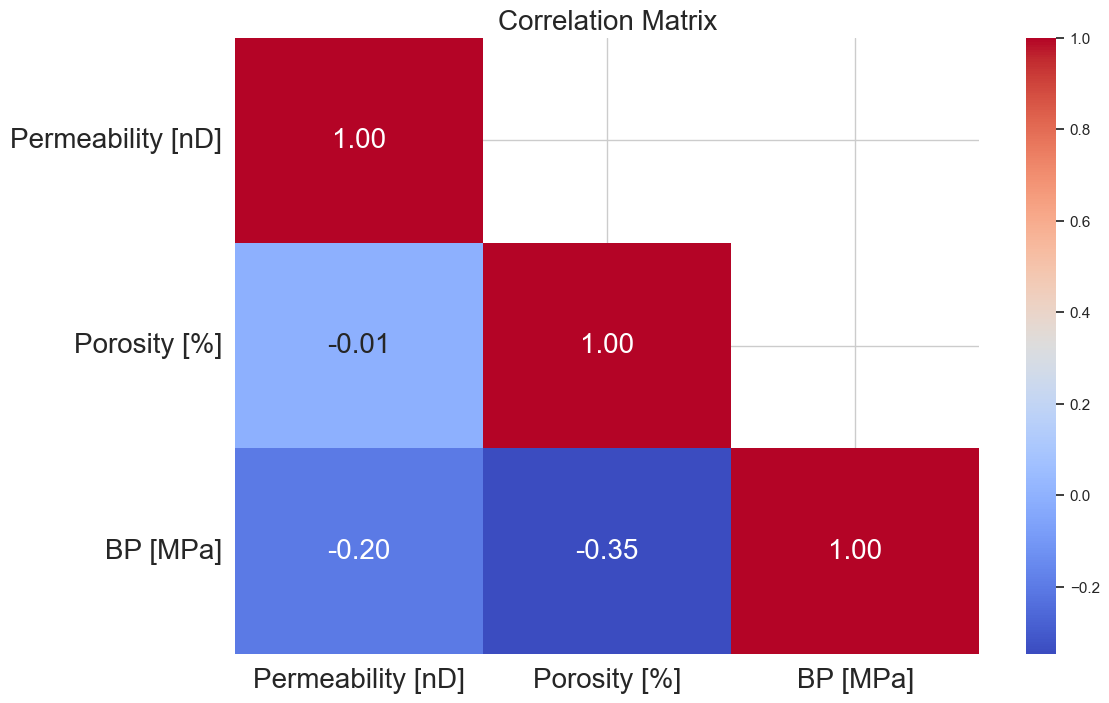

In [46]:
df.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['Permeability [nD]', 'Porosity [%]',  'BP [MPa]']
correlation_matrix = df[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(fontsize=20, fontname='Arial')
plt.show()

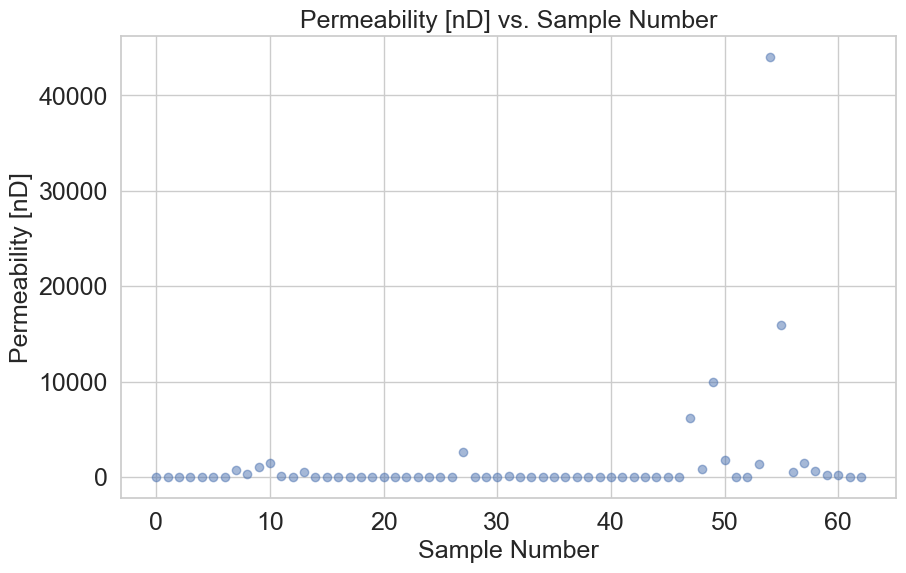

In [47]:

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Permeability [nD]'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18, fontname='Arial')
plt.ylabel('Permeability [nD]', fontsize=18, fontname='Arial')
plt.title('Permeability [nD] vs. Sample Number', fontsize=18, fontname='Arial')
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()


## Data Preprocessing

In [48]:
df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [49]:
feature_columns = ['P’[MPa]','Permeability [nD]', 'Porosity [%]']
target_column= 'BP [MPa]'

In [50]:
# Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [51]:
# Replace special symbols in column names
df = df.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3', 'BP [MPa]':'Target'})
df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'Target'], dtype='object')


In [52]:
feature_columns = ['P1', 'P2', 'P3']
target_column= 'Target'

In [53]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
X_train.shape

(50, 3)

In [55]:
X_test.shape

(13, 3)

## Model Building


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 9.507762424158155
Mean Absolute Error (MAE): 2.054512728544382
R-squared (R2): 0.2397785316882327


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/1919750084.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


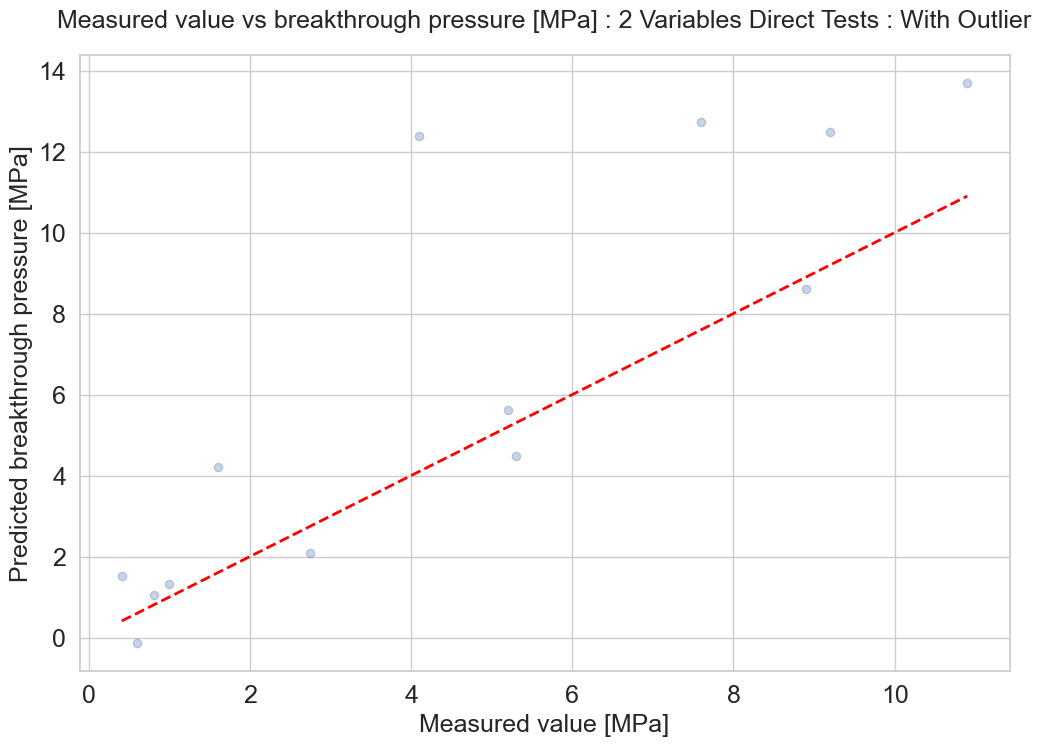

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured value vs breakthrough pressure [MPa] : 2 Variables Direct Tests : With Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

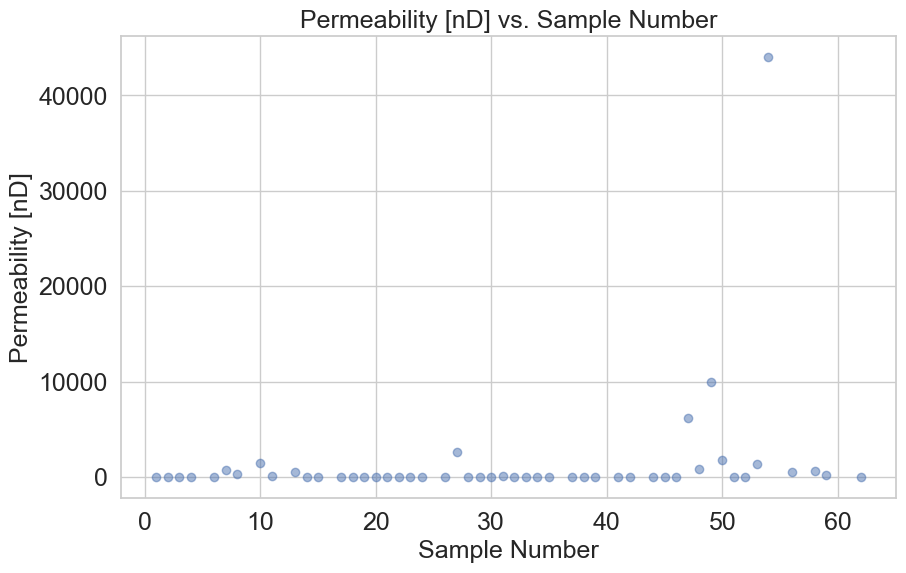

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_train.index, X_train['P2'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18)
plt.ylabel('Permeability [nD]', fontsize=18)
plt.title('Permeability [nD] vs. Sample Number', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [58]:
df[df['P2']>10000]

,Reference,Rock,P1,P2,P3,Target
54,3,3,NaN,44000.0,17.0,0.31
55,3,3,NaN,16000.0,14.5,0.60


In [59]:
df = df[df['P2']<10000]

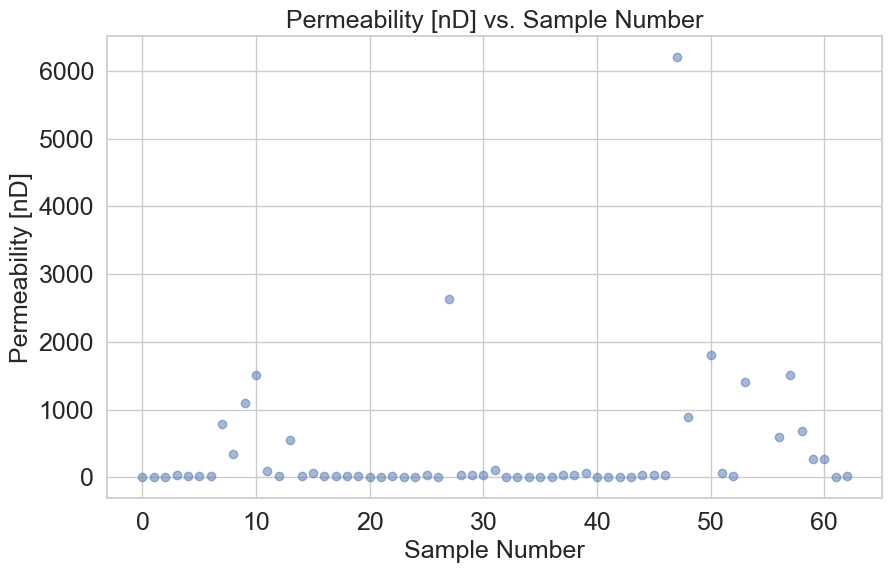

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['P2'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18, fontname='Arial')
plt.ylabel('Permeability [nD]', fontsize=18, fontname='Arial')
plt.title('Permeability [nD] vs. Sample Number', fontsize=18, fontname='Arial')
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()


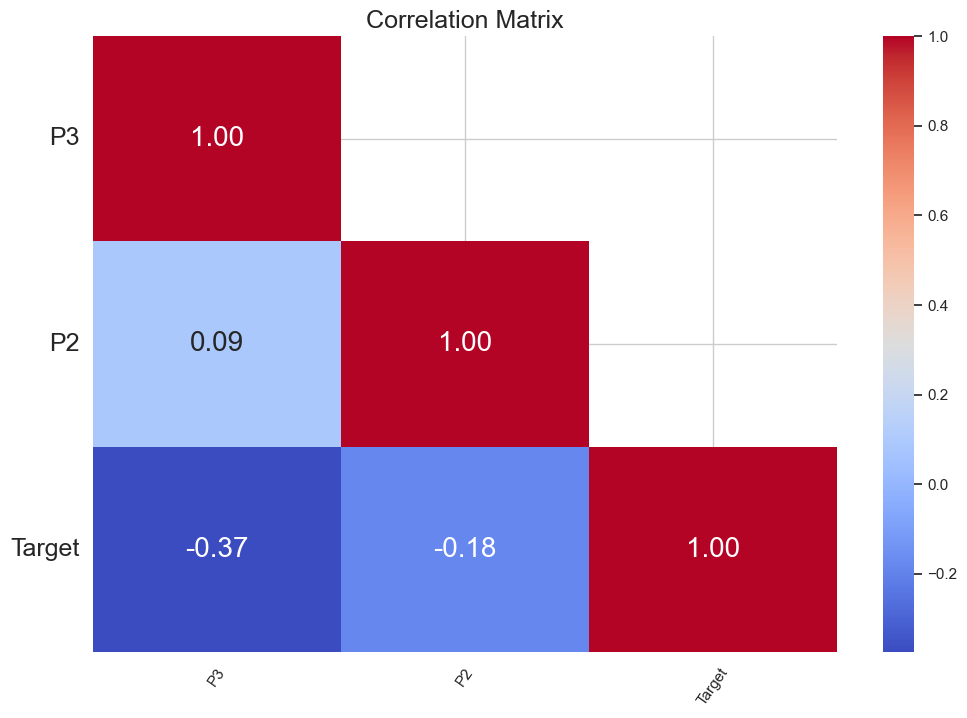

In [61]:
#df.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['P3', 'P2',  'Target']
correlation_matrix = df[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=18, fontname='Arial')
plt.yticks(rotation=0, fontsize=18, fontname='Arial')
plt.xticks(rotation=55, fontname='Arial')
plt.show()

In [62]:
df.shape

(60, 6)

In [63]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train.shape

(48, 3)

In [65]:
X_test.shape

(12, 3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (MSE): 39.03045370854596
Mean Absolute Error (MAE): 3.6076805496215822
R-squared (R2): 0.27606806945645257


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/2078199353.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


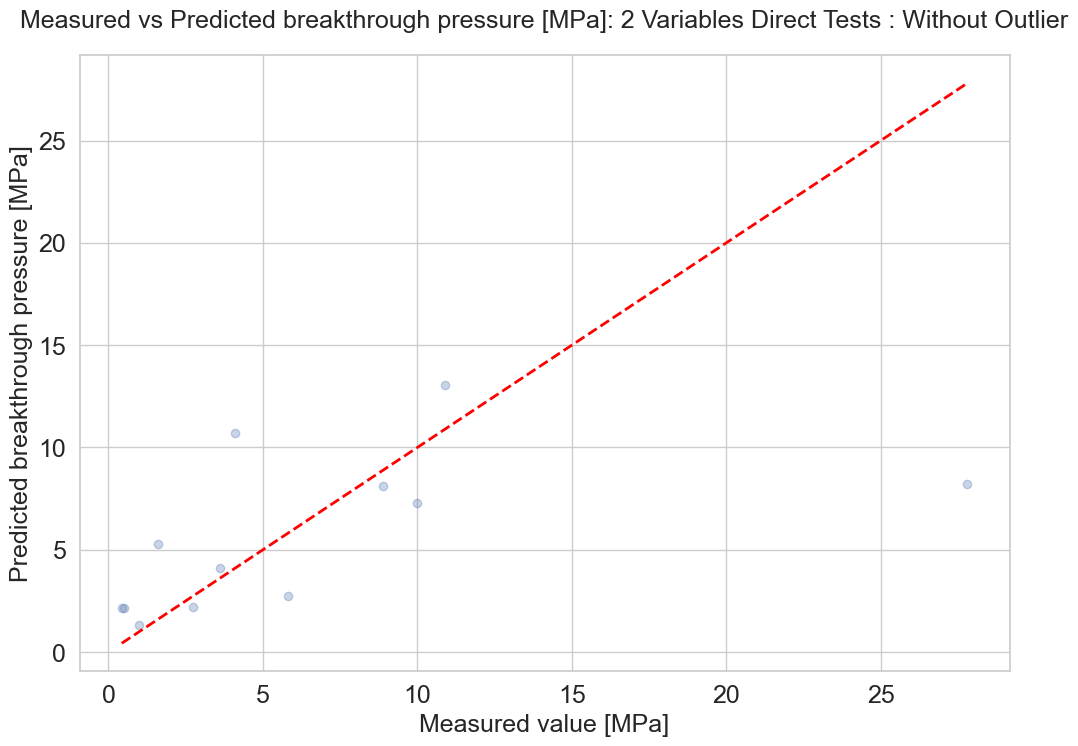

In [66]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18)
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18)
plt.title('Measured vs Predicted breakthrough pressure [MPa]: 2 Variables Direct Tests : Without Outlier', fontsize=18, pad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Prediction of Breakthrough Pressure with 5 Variables: Direct Tests

## Exploratory Data Analysis

In [67]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

In [68]:
# Display the summary statistics
print("\nSummary statistics:")
df1.describe()


Summary statistics:


,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
count,36.000000,36.000000,36.000000,34.000000,36.000000,36.000000,36.000000
mean,14.325000,215.816667,19.383333,35.142059,38.083333,47.488889,4.438056
std,6.905872,530.239750,12.378357,73.319969,34.120898,28.823807,4.120411
min,5.000000,2.000000,5.000000,0.600000,4.000000,0.000000,0.400000
25%,8.875000,9.250000,12.000000,11.000000,20.000000,31.000000,0.840000
50%,15.000000,29.650000,15.000000,14.900000,30.000000,48.600000,3.800000
75%,20.000000,61.200000,24.000000,21.100000,56.250000,56.000000,5.850000
max,25.000000,2634.000000,54.500000,320.000000,170.000000,100.000000,17.500000


In [69]:
# Check for missing values
print("\nMissing values in each column:")
print(df1.isnull().sum())


Missing values in each column:
Reference                      0
Rock                           0
P’[MPa]                        0
Permeability [nD]              0
Porosity [%]                   0
SSA [m2g-1]                    2
Pore diameter [nm]             0
Clay content [%]               0
Breakthrough pressure [MPa]    0
dtype: int64


In [70]:
# Check the data types of each column
print("\nData types of each column:")
print(df1.dtypes)


Data types of each column:
Reference                       object
Rock                            object
P’[MPa]                        float64
Permeability [nD]              float64
Porosity [%]                   float64
SSA [m2g-1]                    float64
Pore diameter [nm]             float64
Clay content [%]               float64
Breakthrough pressure [MPa]    float64
dtype: object


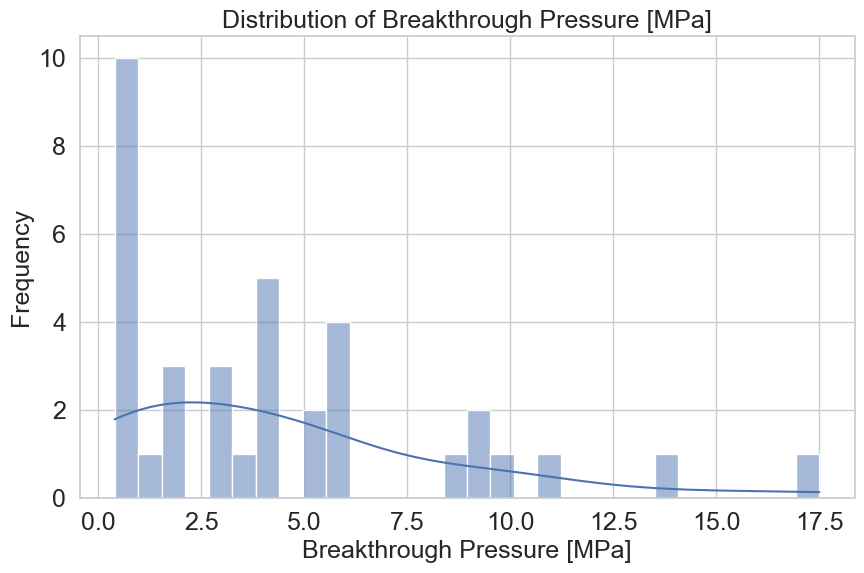

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(df1['Breakthrough pressure [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]', fontsize=18, fontname='Arial')
plt.xlabel('Breakthrough Pressure [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Frequency', fontsize=18, fontname='Arial')
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

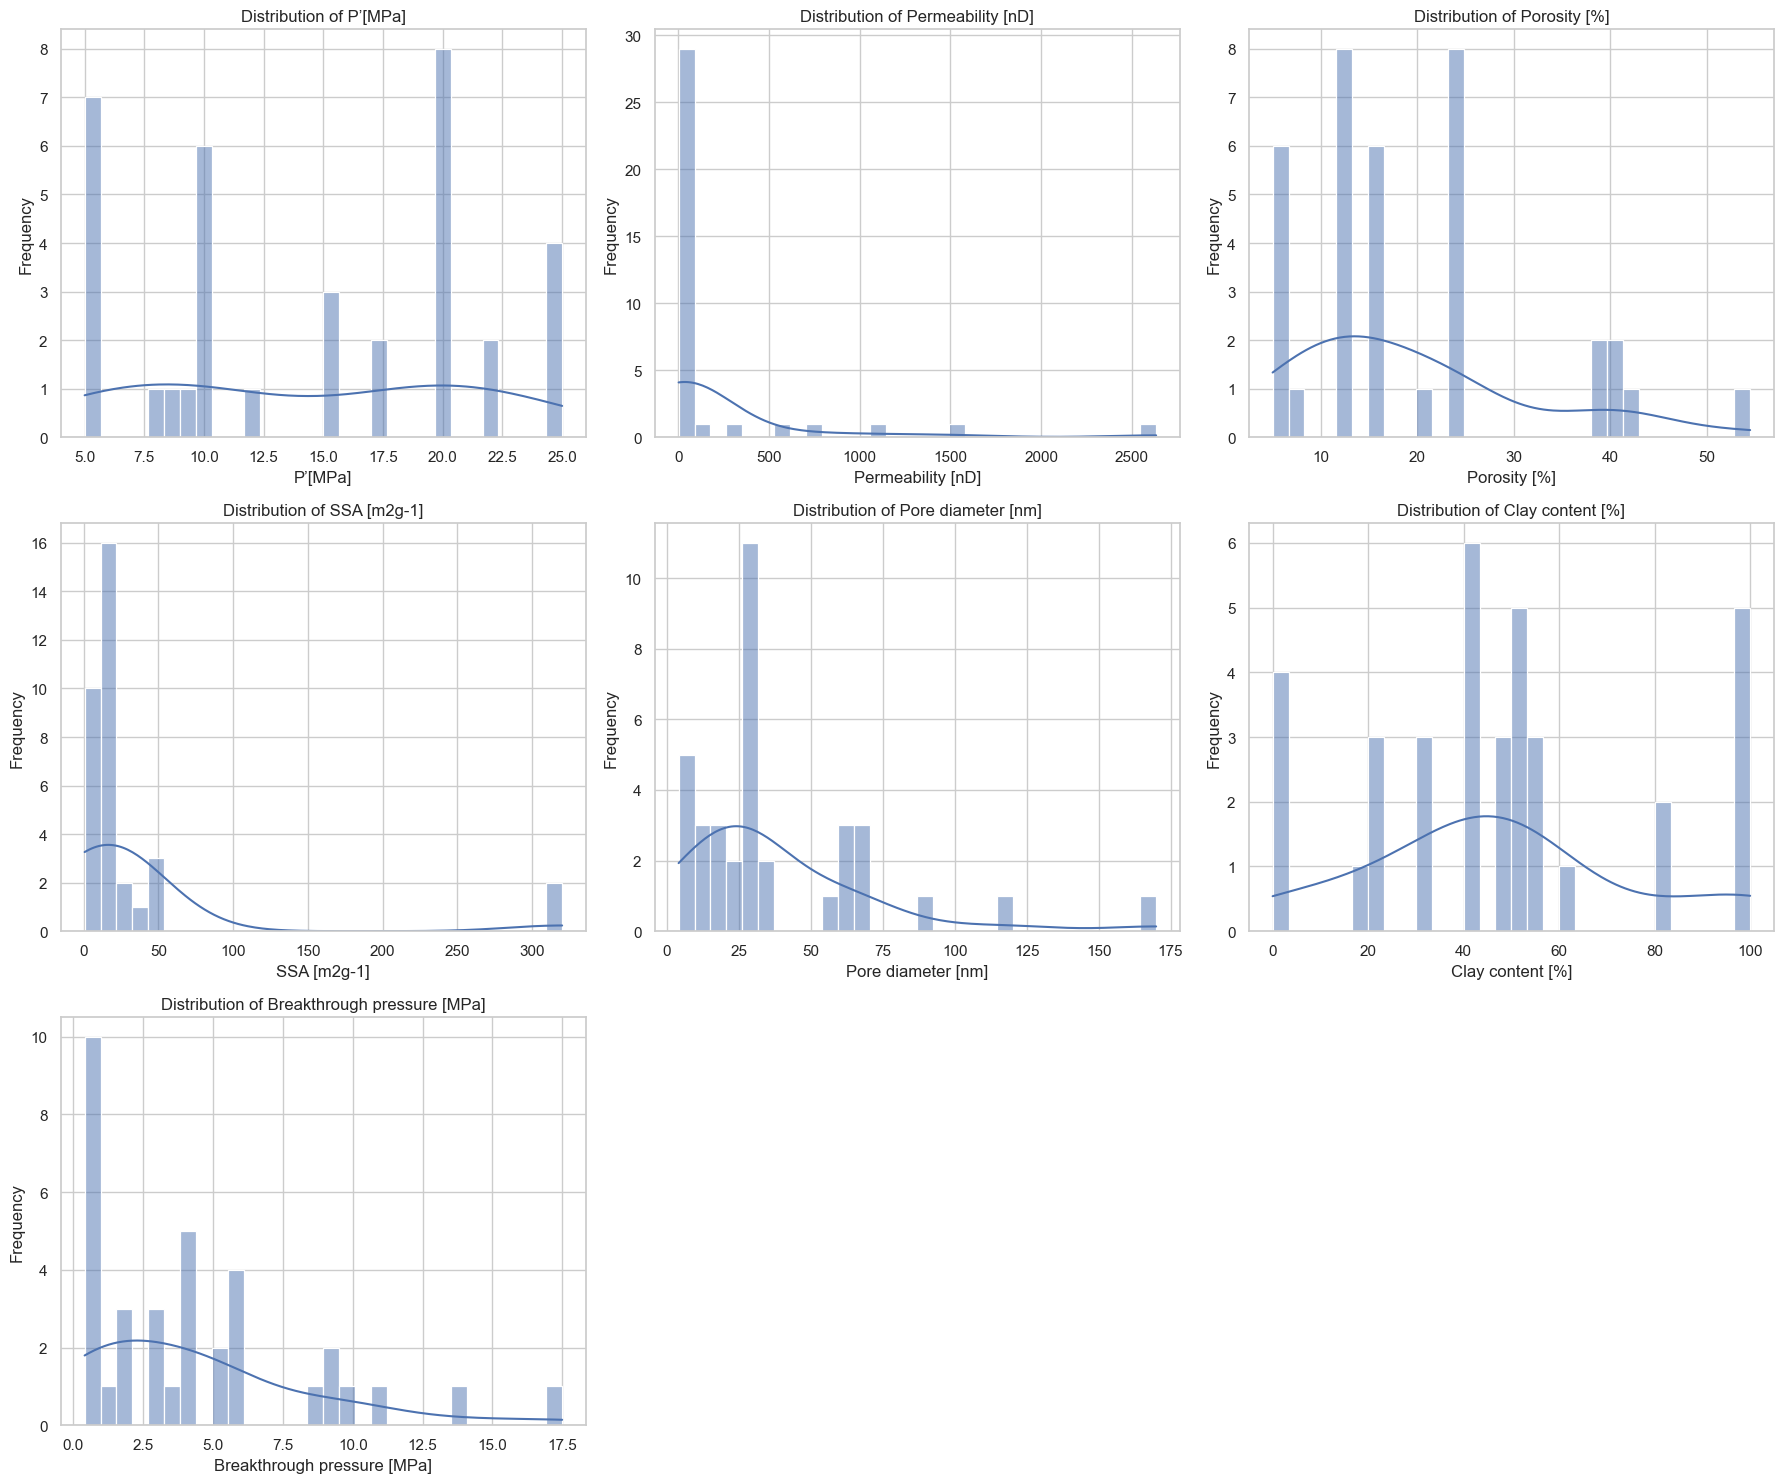

In [72]:
feature_columns = ['P’[MPa]',
       'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]',
       'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df1[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [73]:
df1.head()

,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


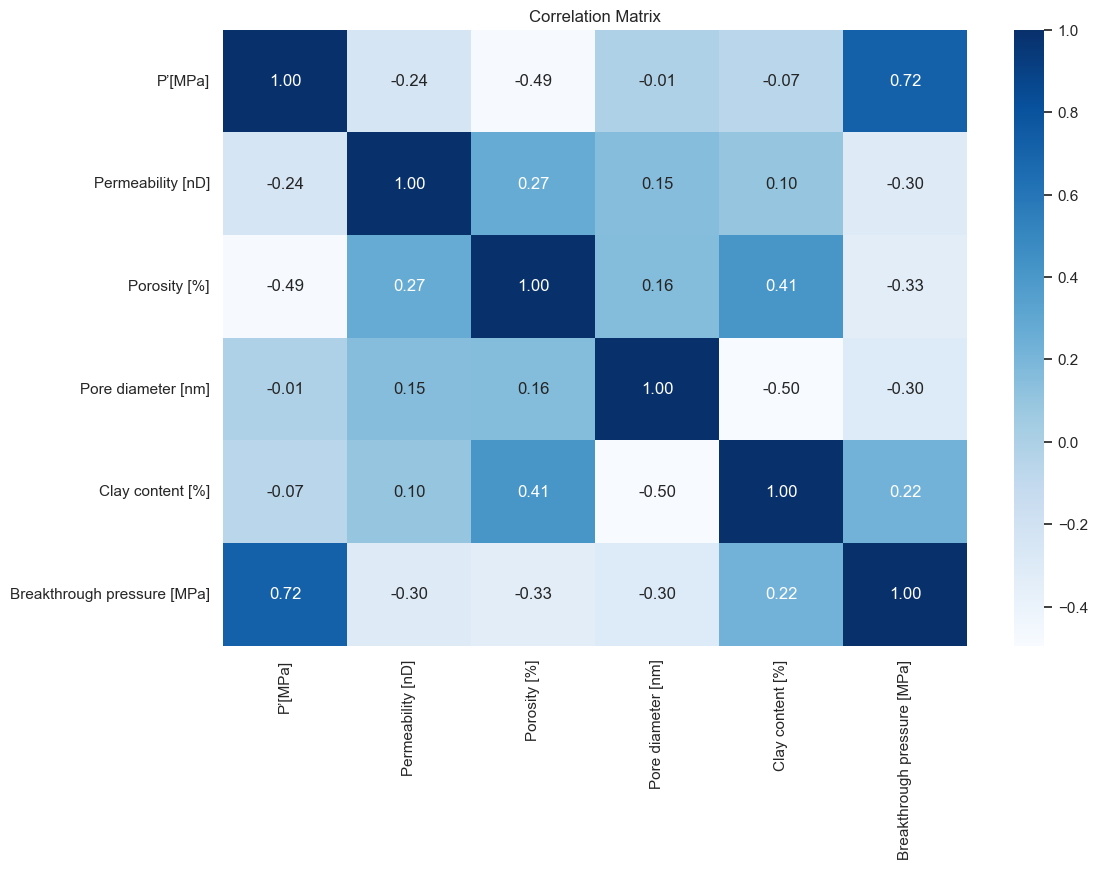

In [74]:
# Visualize correlations between features and the target variable
cols = ['P’[MPa]',
       'Permeability [nD]', 'Porosity [%]',
       'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']
correlation_matrix = df1[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

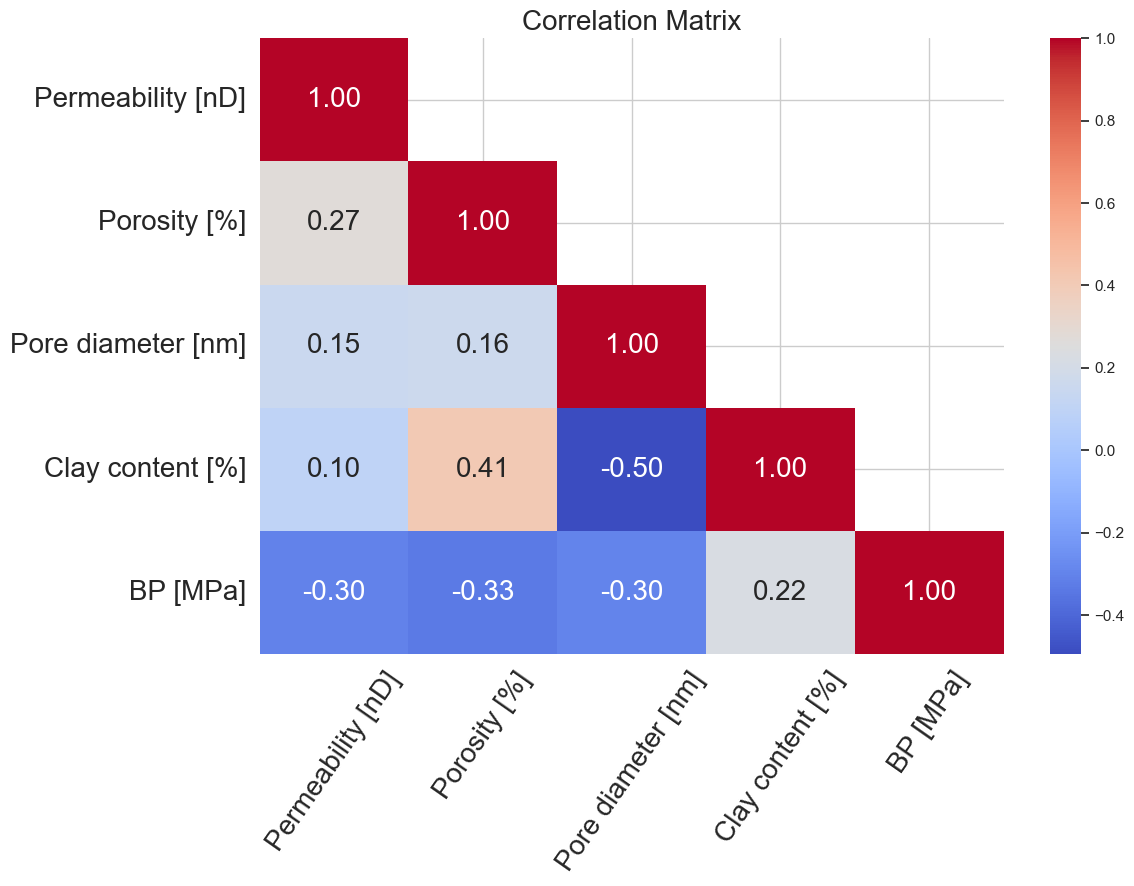

In [75]:
df1.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['Permeability [nD]', 'Porosity [%]', 
       'Pore diameter [nm]', 'Clay content [%]',
       'BP [MPa]']
correlation_matrix = df1[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', 
            fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontsize=20, fontname='Arial')
plt.show()

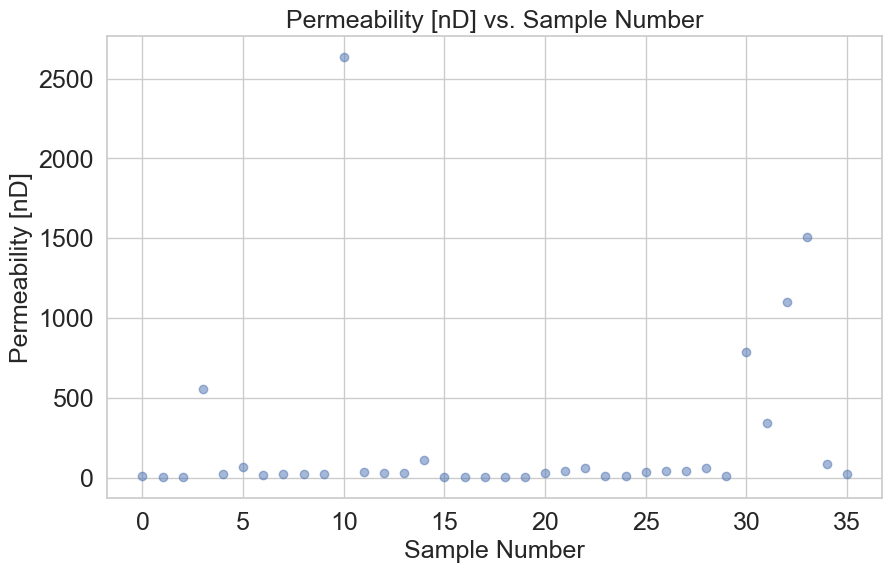

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(df1.index, df1['Permeability [nD]'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18)
plt.ylabel('Permeability [nD]', fontsize=18)
plt.title('Permeability [nD] vs. Sample Number', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Data Preprocessing

In [77]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [78]:
feature_columns = [
       'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]',
       'Pore diameter [nm]', 'Clay content [%]']
target_column= 'BP [MPa]'

In [79]:
# Encoding
label_encoders = {}
for column in df1.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df1[column] = label_encoders[column].fit_transform(df1[column])
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [80]:
# Replace special symbols in column names
df1 = df1.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3','Pore diameter [nm]': 'P4',
                          'Clay content [%]': 'P5', 'SSA [m2g-1]': 'P6','BP [MPa]':'Target'})
df1.columns = df1.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df1.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'P6', 'P4', 'P5', 'Target'], dtype='object')


In [81]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
target_column= 'Target'
X = df1[feature_columns]
y = df1[target_column]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 6)

In [83]:
X_test.shape

(8, 6)

## Model Building

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Mean Squared Error (MSE): 1.4037250694476213
Mean Absolute Error (MAE): 1.0191778671741485
R-squared (R2): 0.8317390567206255


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/756005667.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


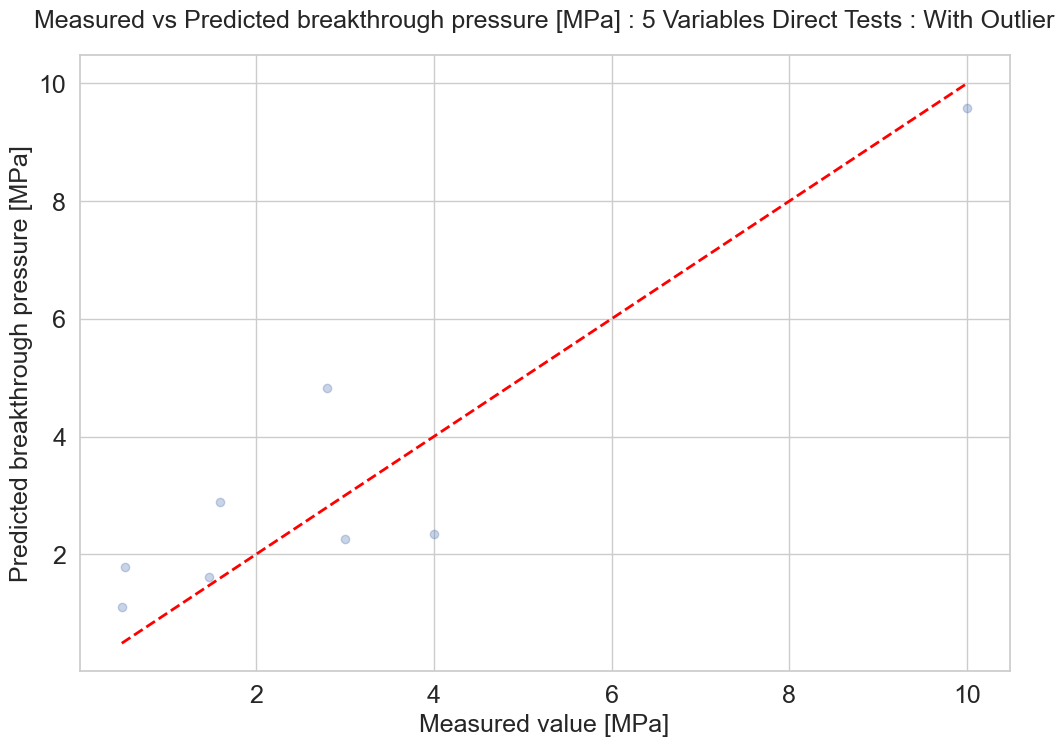

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : With Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

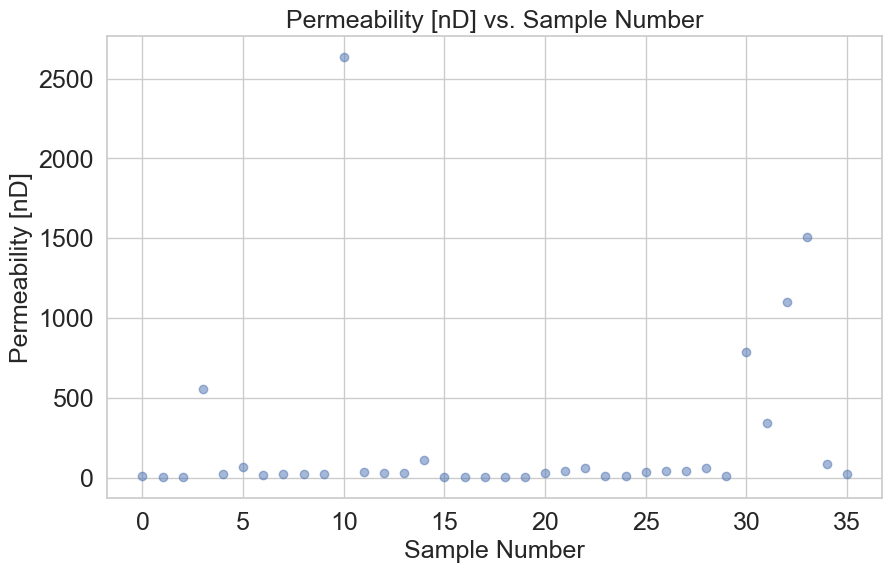

In [85]:

plt.figure(figsize=(10, 6))
plt.scatter(df1.index, df1['P2'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18)
plt.ylabel('Permeability [nD]', fontsize=18)
plt.title('Permeability [nD] vs. Sample Number', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [86]:
df1 = df1[df1['P2']<10000]

In [87]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5']
target_column= 'Target'

In [88]:
X = df1[feature_columns]
y = df1[target_column]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 5)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 1.212273744496226
Mean Absolute Error (MAE): 0.9074617311358452
R-squared (R2): 0.8546878386648593


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/3843787220.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


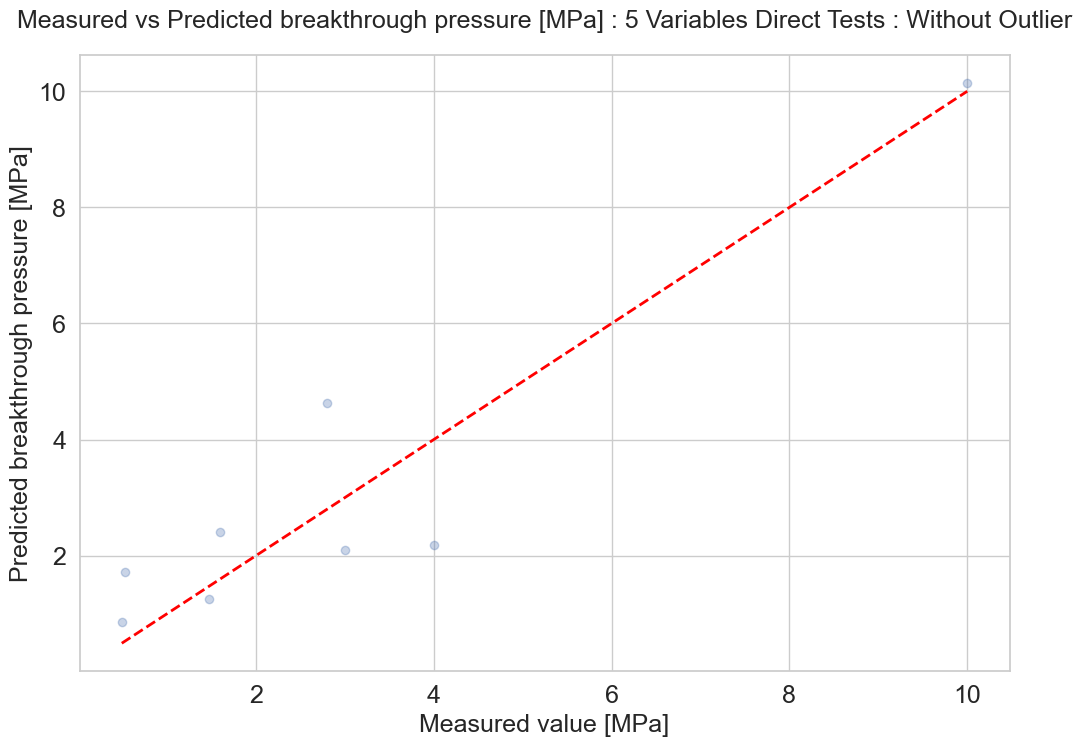

In [90]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : Without Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

In [91]:
df.columns

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'Target'], dtype='object')

# Physics Informed Neural Network

In [92]:
# Load the dataset
df = pd.read_csv('final2.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


In [93]:
df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

In [94]:
df.dropna(inplace=True)

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Features and target
X = df[['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]']]
y = df['Breakthrough pressure [MPa]']

In [96]:
X

,Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%]
0,6.9,11.6,39.00,14.0,60.0
3,557.0,24.4,20.10,170.0,3.0
4,24.3,23.5,23.60,55.0,40.0
5,64.8,23.4,20.60,21.0,31.0
6,17.2,23.4,20.60,21.0,31.0
7,22.0,24.0,48.20,60.0,56.0
8,23.3,24.0,48.20,60.0,56.0
9,19.3,24.0,48.20,60.0,56.0
10,2634.0,8.0,3.93,35.0,33.0
11,32.5,12.0,13.60,20.0,40.0


In [97]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Check for NaNs or zero values in 'Pore diameter [nm]' and clip small values
X_train['Pore diameter [nm]'] = X_train['Pore diameter [nm]'].clip(lower=1e-6)
X_test['Pore diameter [nm]'] = X_test['Pore diameter [nm]'].clip(lower=1e-6)

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim


class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)
        
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.01)
        
        self.fc4 = nn.Linear(16, 1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
    
    def forward(self, x):
        x = self.leaky_relu1(self.bn1(self.fc1(x)))
        x = self.leaky_relu2(self.bn2(self.fc2(x)))
        x = self.leaky_relu3(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Custom physics-informed loss function
def physics_informed_loss(predictions, targets, pore_diameter):
    mse_loss = nn.MSELoss()(predictions, targets)
    
    bp_physics = 104 / (pore_diameter + 1e-6)
    physics_loss = nn.MSELoss()(predictions, bp_physics.view(-1, 1))
    
    total_loss = mse_loss + 0.1 * physics_loss
    return total_loss

model = PhysicsInformedNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    
    optimizer.zero_grad()
    
    predictions = model(X_train_tensor)
    
    pore_diameter_train = torch.tensor(X_train['Pore diameter [nm]'].values, dtype=torch.float32)
    loss = physics_informed_loss(predictions, y_train_tensor, pore_diameter_train)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}')

# Testing
model.eval()
with torch.no_grad():
    
    predictions_test = model(X_test_tensor)
    pore_diameter_test = torch.tensor(X_test['Pore diameter [nm]'].values, dtype=torch.float32)
    test_loss = physics_informed_loss(predictions_test, y_test_tensor, pore_diameter_test)
    print(f'Test Loss: {test_loss.item()}')

Epoch 0/100, Loss: 30.5810489654541
Epoch 10/100, Loss: 29.756868362426758
Epoch 20/100, Loss: 29.029870986938477
Epoch 30/100, Loss: 28.39996337890625
Epoch 40/100, Loss: 27.847328186035156
Epoch 50/100, Loss: 27.360353469848633
Epoch 60/100, Loss: 26.94208526611328
Epoch 70/100, Loss: 26.582181930541992
Epoch 80/100, Loss: 26.278562545776367
Epoch 90/100, Loss: 25.993480682373047
Test Loss: 28.24645233154297


In [99]:
predictions_test

tensor([[1.2521],
        [0.3122],
        [0.4507],
        [0.4743],
        [2.8783],
        [0.0965],
        [0.4151]])

Mean Absolute Error (MAE): 3.2010488380704607
Mean Squared Error (MSE): 18.885608453212317
R-squared (R2): -0.5835633184297815


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/1349975023.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


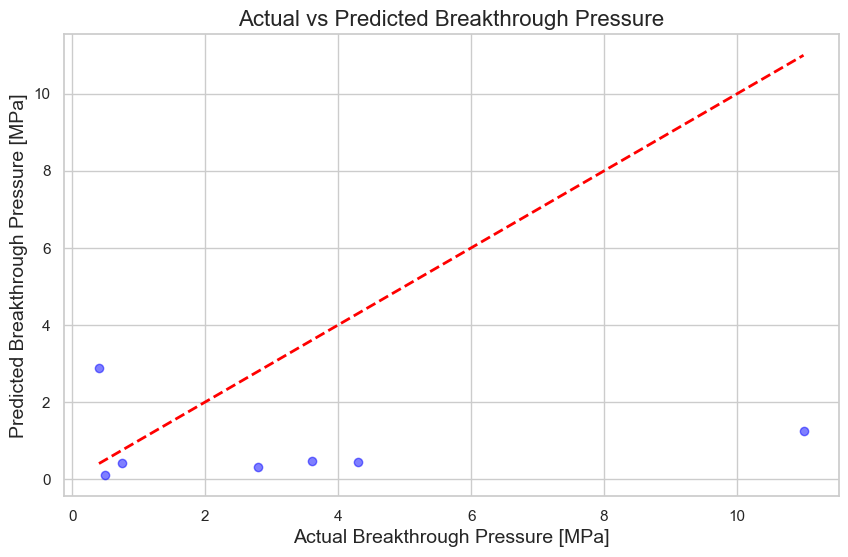

In [100]:
# Calculate MAE, MSE, and R-squared
mae = mean_absolute_error(y_test, predictions_test)
mse = mean_squared_error(y_test, predictions_test)
r2 = r2_score(y_test, predictions_test)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Plotting Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_test, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=14)
plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=14)
plt.title('Actual vs Predicted Breakthrough Pressure', fontsize=16)
plt.show()

In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming your dataset is in df
# Features and target
X = df[['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]']]
y = df['Breakthrough pressure [MPa]']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable without log transform
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))  # Fit and transform on raw data
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))  # Transform test data

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Define the neural network with LeakyReLU, batch normalization, and a deeper architecture
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)  # Increased number of neurons in input layer
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization layer for the first hidden layer
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU for first layer
        
        self.fc2 = nn.Linear(256, 128)  # Hidden layer 1
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization for hidden layer 1
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU for second layer
        
        self.fc3 = nn.Linear(128, 64)  # Hidden layer 2
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization for hidden layer 2
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU for third layer
        
        self.fc4 = nn.Linear(64, 32)  # Hidden layer 3
        self.bn4 = nn.BatchNorm1d(32)  # Batch normalization for hidden layer 3
        self.leaky_relu4 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU for fourth layer
        
        self.fc5 = nn.Linear(32, 1)  # Output layer
        
        # Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)
    
    def forward(self, x):
        # Forward pass with batch normalization and LeakyReLU activation
        x = self.leaky_relu1(self.bn1(self.fc1(x)))
        x = self.leaky_relu2(self.bn2(self.fc2(x)))
        x = self.leaky_relu3(self.bn3(self.fc3(x)))
        x = self.leaky_relu4(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

# Custom physics-informed loss function
def physics_informed_loss(predictions, targets, pore_diameter):
    mse_loss = nn.MSELoss()(predictions, targets)
    
    # Physics-informed regularization term based on BP = 104 / (d + 1e-6)
    bp_physics = 104 / (pore_diameter + 1e-6)
    physics_loss = nn.MSELoss()(predictions, bp_physics.view(-1, 1))
    
    # Combine both losses
    total_loss = mse_loss + 0.1 * physics_loss
    return total_loss

# Instantiate the model
model = PhysicsInformedNN()

# Optimizer with a smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Scheduler to adjust learning rate during training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Training loop with gradient clipping and learning rate scheduling
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_train_tensor)
    
    # Compute the loss
    pore_diameter_train = torch.tensor(X_train['Pore diameter [nm]'].values, dtype=torch.float32)
    loss = physics_informed_loss(predictions, y_train_tensor, pore_diameter_train)
    
    # Backward pass and optimization with gradient clipping
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Step the learning rate scheduler
    scheduler.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}')

# Testing
model.eval()
with torch.no_grad():
    predictions_test = model(X_test_tensor)
    pore_diameter_test = torch.tensor(X_test['Pore diameter [nm]'].values, dtype=torch.float32)
    test_loss = physics_informed_loss(predictions_test, y_test_tensor, pore_diameter_test)
    print(f'Test Loss: {test_loss.item()}')

    # Inverse transform the predictions to the original scale
    predictions_test_inverse = y_scaler.inverse_transform(predictions_test.detach().numpy())
    y_test_inverse = y_scaler.inverse_transform(y_test_tensor.detach().numpy())

# Calculate MAE, MSE, and R-squared
mae = mean_absolute_error(y_test_inverse, predictions_test_inverse)
mse = mean_squared_error(y_test_inverse, predictions_test_inverse)
r2 = r2_score(y_test_inverse, predictions_test_inverse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Epoch 0/100, Loss: 11.140239715576172
Epoch 10/100, Loss: 8.518499374389648
Epoch 20/100, Loss: 7.582629203796387
Epoch 30/100, Loss: 7.1535325050354
Epoch 40/100, Loss: 6.901778221130371
Epoch 50/100, Loss: 6.74049186706543
Epoch 60/100, Loss: 6.631979942321777
Epoch 70/100, Loss: 6.557568073272705
Epoch 80/100, Loss: 6.5052947998046875
Epoch 90/100, Loss: 6.468497276306152
Test Loss: 8.753392219543457
Mean Absolute Error (MAE): 0.9152413606643677
Mean Squared Error (MSE): 1.575884222984314
R-squared (R2): 0.8678616686899666


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_94469/4039957755.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'k--', lw=2, color='red')


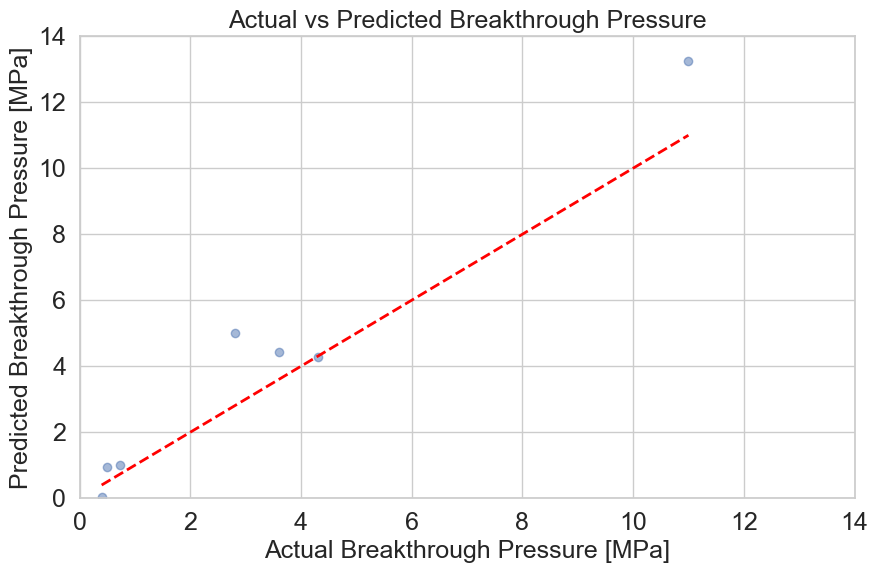

In [146]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inverse, predictions_test_inverse, alpha=0.5)

plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'k--', lw=2, color='red')

plt.xlim([0, 12])
plt.ylim([0, 12])

plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=18)
plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=18)
plt.title('Actual vs Predicted Breakthrough Pressure', fontsize=18)

plt.xticks(np.arange(0, 16, 2), fontsize=18)
plt.yticks(np.arange(0, 16, 2), fontsize=18)

plt.show()